## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

詳細可參考：
https://blog.gtwang.org/programming/keras-save-and-load-model-tutorial/

In [21]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [22]:
train, test = keras.datasets.cifar10.load_data()

In [23]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [24]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [25]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [26]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95
# save_bests=[0,1]

In [30]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint


results = {}
results_save = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
# for save_best in save_bests:
id_ = 'save_best'
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                         monitor="val_loss", 
                         save_best_only=True,
                         save_weights_only=True)


model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# model.save_weights('Day86_weight.h5')
model.load_weights('Day86_weight.h5')

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )


# Collect results
results[id_] = {
        'train_loss' : model.history.history["loss"]
        ,'valid_loss' : model.history.history["val_loss"]
        ,'train_acc' : model.history.history["acc"]
        ,'valid_acc' : model.history.history["val_acc"]
    }
# model = keras.models.load_model("./tmp.h5")
# loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
# results_save[id_] = {'valid_loss': loss_loadback
#                      ,'valid_acc': acc_loadback
# }


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
__________

In [20]:
# model = keras.models.load_model("./tmp.h5")
model = keras.models.load_weights("Day86_weight.h5")
# loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
# results_save[id_] = {'valid_loss': loss_loadback
#                      ,'valid_acc': acc_loadback
# }

AttributeError: module 'keras.models' has no attribute 'load_weights'

0 save_best


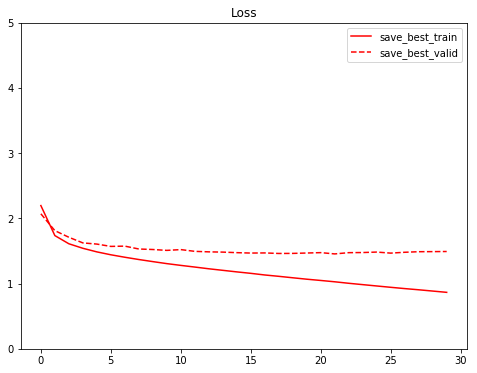

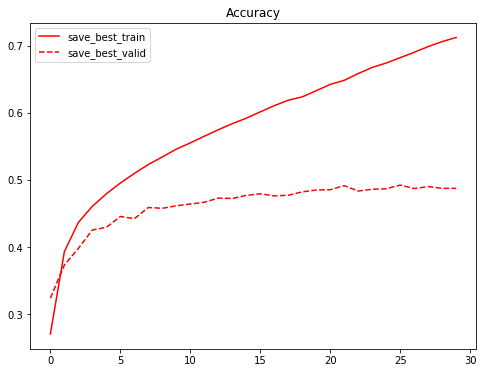

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()